In [ ]:
!pip install transformers evaluate datasets

In [ ]:
import requests
import torch
from PIL import Image
from transformers import *
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# the model name
model_name = "google/vit-base-patch16-224"
# load the image processor
image_processor = ViTImageProcessor.from_pretrained(model_name)
# loading the pre-trained model
model = ViTForImageClassification.from_pretrained(model_name).to(device)

In [4]:
import urllib.parse as parse
import os

# a function to determine whether a string is a URL or not
def is_url(string):
    try:
        result = parse.urlparse(string)
        return all([result.scheme, result.netloc, result.path])
    except:
        return False
    
# a function to load an image
def load_image(image_path):
    if is_url(image_path):
        return Image.open(requests.get(image_path, stream=True).raw)
    elif os.path.exists(image_path):
        return Image.open(image_path)

In [5]:
def get_prediction(model, url_or_path):
  # load the image
  img = load_image(url_or_path)
  # preprocessing the image
  pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
  # perform inference
  output = model(pixel_values)
  # get the label id and return the class name
  return model.config.id2label[int(output.logits.softmax(dim=1).argmax())]

In [6]:
get_prediction(model, "http://images.cocodataset.org/test-stuff2017/000000000128.jpg")

'Indian elephant, Elephas maximus'

# Loading our Dataset

In [5]:
from datasets import load_dataset

# download & load the dataset
ds = load_dataset("food101")

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Loading a Custom Dataset using `ImageFolder`
Run the three below cells to load a custom dataset (that's not in the Hub) using `ImageFolder`

In [6]:
import requests
from tqdm import tqdm

def get_file(url):
  response = requests.get(url, stream=True)
  total_size = int(response.headers.get('content-length', 0))
  filename = None
  content_disposition = response.headers.get('content-disposition')
  if content_disposition:
      parts = content_disposition.split(';')
      for part in parts:
          if 'filename' in part:
              filename = part.split('=')[1].strip('"')
  if not filename:
      filename = os.path.basename(url)
  block_size = 1024 # 1 Kibibyte
  tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
  with open(filename, 'wb') as file:
      for data in response.iter_content(block_size):
          tqdm_bar.update(len(data))
          file.write(data)
  tqdm_bar.close()
  print(f"Downloaded {filename} ({total_size} bytes)")
  return filename

In [7]:
import zipfile
import os

def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    data_dir = get_file(download_link)
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(data_dir)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

100%|██████████| 865M/865M [00:47<00:00, 18.1MiB/s]


Downloaded valid.zip (864538487 bytes)
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip


100%|██████████| 5.74G/5.74G [05:39<00:00, 16.9MiB/s]


Downloaded train.zip (5736557430 bytes)
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip


100%|██████████| 5.53G/5.53G [04:53<00:00, 18.9MiB/s]


Downloaded test.zip (5528640507 bytes)
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [5]:
from datasets import load_dataset

# load the custom dataset
ds = load_dataset("imagefolder", data_dir="data")

Resolving data files:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/600 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

# Exploring the Data

In [12]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [13]:
labels = ds["train"].features["label"]
labels

ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'mac

In [14]:
labels.int2str(ds["train"][532]["label"])

'beignets'

In [10]:
import random
import matplotlib.pyplot as plt

def show_image_grid(dataset, split, grid_size=(4,4)):
    # Select random images from the given split
    indices = random.sample(range(len(dataset[split])), grid_size[0]*grid_size[1])
    images = [dataset[split][i]["image"] for i in indices]
    labels = [dataset[split][i]["label"] for i in indices]
    
    # Display the images in a grid
    fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(8,8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
        ax.set_title(ds["train"].features["label"].int2str(labels[i]))
    
    plt.show()

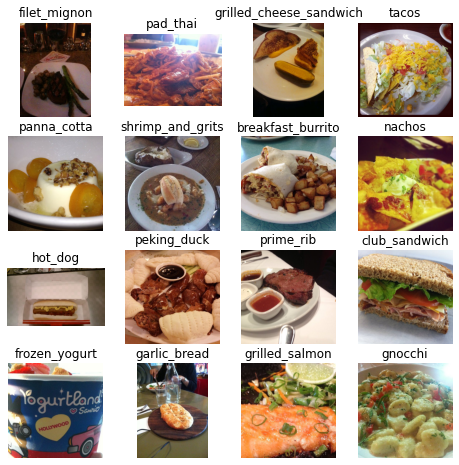

In [11]:
show_image_grid(ds, "train")

# Preprocessing the Data

In [10]:
def transform(examples):
  # convert all images to RGB format, then preprocessing it
  # using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")
  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]
  return inputs

In [11]:
# use the with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

In [12]:
for item in dataset["train"]:
  print(item["pixel_values"].shape)
  print(item["labels"])
  break

torch.Size([3, 224, 224])
6


In [15]:
# extract the labels for our dataset
labels = ds["train"].features["label"].names
labels

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [13]:
import torch

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch]),
  }

# Defining the Metrics

In [14]:
from evaluate import load
import numpy as np

# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred):
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=np.argmax(eval_pred.predictions, axis=1), references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

# Training the Model

In [ ]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

In [17]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-food", # output directory
  # output_dir="./vit-base-skin-cancer",
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=3,             # total number of training epochs
  # fp16=True,                    # use mixed precision
  save_steps=1000,                # number of update steps before saving checkpoint
  eval_steps=1000,                # number of update steps before evaluating
  logging_steps=1000,             # number of update steps before logging
  # save_steps=50,
  # eval_steps=50,
  # logging_steps=50,
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)


PyTorch: setting up devices


In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,                        # the instantiated 🤗 Transformers model to be trained
    args=training_args,                 # training arguments, defined above
    data_collator=collate_fn,           # the data collator that will be used for batching
    compute_metrics=compute_metrics,    # the metrics function that will be used for evaluation
    train_dataset=dataset["train"],     # training dataset
    eval_dataset=dataset["validation"], # evaluation dataset
    tokenizer=image_processor,          # the processor that will be used for preprocessing the images
)

In [19]:
# start training
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 75750
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 7104
  Number of trainable parameters = 85876325


Step,Training Loss,Validation Loss,Accuracy,F1
1000,1.440300,0.582373,0.853149,0.852764
2000,0.703100,0.453642,0.878297,0.878230
3000,0.434700,0.409464,0.886455,0.886492
4000,0.310100,0.394801,0.889188,0.888990
5000,0.245100,0.383308,0.895168,0.895035
6000,0.115700,0.379927,0.896515,0.896743
7000,0.108100,0.376985,0.898059,0.898311


***** Running Evaluation *****
  Num examples = 25250
  Batch size = 8
Saving model checkpoint to ./vit-base-food/checkpoint-1000
Configuration saved in ./vit-base-food/checkpoint-1000/config.json
Model weights saved in ./vit-base-food/checkpoint-1000/pytorch_model.bin
Image processor saved in ./vit-base-food/checkpoint-1000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 25250
  Batch size = 8
Saving model checkpoint to ./vit-base-food/checkpoint-2000
Configuration saved in ./vit-base-food/checkpoint-2000/config.json
Model weights saved in ./vit-base-food/checkpoint-2000/pytorch_model.bin
Image processor saved in ./vit-base-food/checkpoint-2000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 25250
  Batch size = 8
Saving model checkpoint to ./vit-base-food/checkpoint-3000
Configuration saved in ./vit-base-food/checkpoint-3000/config.json
Model weights saved in ./vit-base-food/checkpoint-3000/pytorch_model.bin
Image processor saved in .

TrainOutput(global_step=7104, training_loss=0.47385838654664186, metrics={'train_runtime': 13577.408, 'train_samples_per_second': 16.737, 'train_steps_per_second': 0.523, 'total_flos': 1.76256801415296e+19, 'train_loss': 0.47385838654664186, 'epoch': 3.0})

In [20]:
# trainer.evaluate(dataset["test"])
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 25250
  Batch size = 8


{'eval_loss': 0.37698468565940857,
 'eval_accuracy': 0.8980594059405941,
 'eval_f1': 0.8983106653355424,
 'eval_runtime': 487.0104,
 'eval_samples_per_second': 51.847,
 'eval_steps_per_second': 6.482,
 'epoch': 3.0}

In [ ]:
# start tensorboard
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir ./vit-base-food/runs

## Alternatively: Training using PyTorch Loop
Run the two below cells to fine-tune using a regular PyTorch loop if you want.

In [ ]:
# Training loop
from torch.utils.tensorboard import SummaryWriter
from torch.optim import AdamW
from torch.utils.data import DataLoader

batch_size = 32

train_dataset_loader = DataLoader(dataset["train"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
valid_dataset_loader = DataLoader(dataset["validation"], collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

# define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

log_dir = "./image-classification/tensorboard"
summary_writer = SummaryWriter(log_dir=log_dir)

num_epochs = 3
model = model.to(device)
# print some statistics before training
# number of training steps
n_train_steps = num_epochs * len(train_dataset_loader)
# number of validation steps
n_valid_steps = len(valid_dataset_loader)
# current training step
current_step = 0
# logging, eval & save steps
save_steps = 1000

def compute_metrics(eval_pred):
  accuracy_score = accuracy.compute(predictions=eval_pred.predictions, references=eval_pred.label_ids)
  f1_score = f1.compute(predictions=eval_pred.predictions, references=eval_pred.label_ids, average="macro")
  return {**accuracy_score, **f1_score}

In [ ]:
for epoch in range(num_epochs):
    # set the model to training mode
    model.train()
    # initialize the training loss
    train_loss = 0
    # initialize the progress bar
    progress_bar = tqdm(range(current_step, n_train_steps), "Training", dynamic_ncols=True, ncols=80)
    for batch in train_dataset_loader:
      if (current_step+1) % save_steps == 0:
        ### evaluation code ###
        # evaluate on the validation set
        # if the current step is a multiple of the save steps
        print()
        print(f"Validation at step {current_step}...")
        print()
        # set the model to evaluation mode
        model.eval()
        # initialize our lists that store the predictions and the labels
        predictions, labels = [], []
        # initialize the validation loss
        valid_loss = 0
        for batch in valid_dataset_loader:
            # get the batch
            pixel_values = batch["pixel_values"].to(device)
            label_ids = batch["labels"].to(device)
            # forward pass
            outputs = model(pixel_values=pixel_values, labels=label_ids)
            # get the loss
            loss = outputs.loss
            valid_loss += loss.item()
            # free the GPU memory
            logits = outputs.logits.detach().cpu()
            # add the predictions to the list
            predictions.extend(logits.argmax(dim=-1).tolist())
            # add the labels to the list
            labels.extend(label_ids.tolist())
        # make the EvalPrediction object that the compute_metrics function expects
        eval_prediction = EvalPrediction(predictions=predictions, label_ids=labels)
        # compute the metrics
        metrics = compute_metrics(eval_prediction)
        # print the stats
        print()
        print(f"Epoch: {epoch}, Step: {current_step}, Train Loss: {train_loss / save_steps:.4f}, " + 
              f"Valid Loss: {valid_loss / n_valid_steps:.4f}, Accuracy: {metrics['accuracy']}, " +
              f"F1 Score: {metrics['f1']}")
        print()
        # log the metrics
        summary_writer.add_scalar("valid_loss", valid_loss / n_valid_steps, global_step=current_step)
        summary_writer.add_scalar("accuracy", metrics["accuracy"], global_step=current_step)
        summary_writer.add_scalar("f1", metrics["f1"], global_step=current_step)
        # save the model
        model.save_pretrained(f"./vit-base-food/checkpoint-{current_step}")
        image_processor.save_pretrained(f"./vit-base-food/checkpoint-{current_step}")
        # get the model back to train mode
        model.train()
        # reset the train and valid loss
        train_loss, valid_loss = 0, 0
      ### training code below ###
      # get the batch & convert to tensor
      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)
      # forward pass
      outputs = model(pixel_values=pixel_values, labels=labels)
      # get the loss
      loss = outputs.loss
      # backward pass
      loss.backward()
      # update the weights
      optimizer.step()
      # zero the gradients
      optimizer.zero_grad()
      # log the loss
      loss_v = loss.item()
      train_loss += loss_v
      # increment the step
      current_step += 1
      progress_bar.update(1)
      # log the training loss
      summary_writer.add_scalar("train_loss", loss_v, global_step=current_step)
        

# Performing Inference

In [ ]:
# load the best model, change the checkpoint number to the best checkpoint
# if the last checkpoint is the best, then ignore this cell
best_checkpoint = 7000
# best_checkpoint = 150
model = ViTForImageClassification.from_pretrained(f"./vit-base-food/checkpoint-{best_checkpoint}").to(device)
# model = ViTForImageClassification.from_pretrained(f"./vit-base-skin-cancer/checkpoint-{best_checkpoint}").to(device)

In [25]:
get_prediction(model, "https://images.pexels.com/photos/858496/pexels-photo-858496.jpeg?auto=compress&cs=tinysrgb&w=600&lazy=load")

'sushi'

In [26]:
def get_prediction_probs(model, url_or_path, num_classes=3):
    # load the image
    img = load_image(url_or_path)
    # preprocessing the image
    pixel_values = image_processor(img, return_tensors="pt")["pixel_values"].to(device)
    # perform inference
    output = model(pixel_values)
    # get the top k classes and probabilities
    probs, indices = torch.topk(output.logits.softmax(dim=1), k=num_classes)
    # get the class labels
    id2label = model.config.id2label
    classes = [id2label[idx.item()] for idx in indices[0]]
    # convert the probabilities to a list
    probs = probs.squeeze().tolist()
    # create a dictionary with the class names and probabilities
    results = dict(zip(classes, probs))
    return results

In [27]:
# example 1
get_prediction_probs(model, "https://images.pexels.com/photos/406152/pexels-photo-406152.jpeg?auto=compress&cs=tinysrgb&w=600")

{'greek_salad': 0.9658474326133728,
 'caesar_salad': 0.019217027351260185,
 'beet_salad': 0.008294313214719296}

In [28]:
# example 2
get_prediction_probs(model, "https://images.pexels.com/photos/920220/pexels-photo-920220.jpeg?auto=compress&cs=tinysrgb&w=600")

{'grilled_cheese_sandwich': 0.9855711460113525,
 'waffles': 0.0030371786560863256,
 'club_sandwich': 0.0017941497499123216}

In [29]:
# example 3
get_prediction_probs(model, "https://images.pexels.com/photos/3338681/pexels-photo-3338681.jpeg?auto=compress&cs=tinysrgb&w=600")

{'donuts': 0.9919546246528625,
 'cup_cakes': 0.0018467127811163664,
 'beignets': 0.0009919782169163227}

In [30]:
# example 4
get_prediction_probs(model, "https://images.pexels.com/photos/806457/pexels-photo-806457.jpeg?auto=compress&cs=tinysrgb&w=600", num_classes=10)

{'deviled_eggs': 0.9846165180206299,
 'caprese_salad': 0.0012617064639925957,
 'ravioli': 0.001060450915247202,
 'beet_salad': 0.0008713295101188123,
 'scallops': 0.0005976424436084926,
 'gnocchi': 0.0005376451299525797,
 'fried_calamari': 0.0005195785779505968,
 'caesar_salad': 0.0003912363899871707,
 'samosa': 0.0003842405858449638,
 'dumplings': 0.00036707069375552237}

In [31]:
get_prediction_probs(model, "https://images.pexels.com/photos/1624487/pexels-photo-1624487.jpeg?auto=compress&cs=tinysrgb&w=600")

{'fried_rice': 0.8101670145988464,
 'paella': 0.06818010658025742,
 'steak': 0.015688087791204453}